# Modulation and Demodulation

In this notebook we will cover modulation of a baseband signal to an allocated Intermediate Frequency (IF) or Radio Frequency (RF) band for transmission and show how this original signal can be perfectly reconstructed at the reciever using demodulation, so long as the carrier frequency is known. 

This will be explored first through a simple Amplitude Modulation and Demodulation example, before exploring how bandwidth efficiency can be improved using Quadrature Amplitude Modulation (QAM). The notebook will conclude by exploring a complex representation of the QAM archetecture and show how this is mathematically identical to the standard QAM form whilst being easier to work with. 

For this notebook we will be using NumPy for computation and MatplotLib for Matlab-like visualisation of our waveforms as well as the included SDR helper functions for plots.

At each stage of this notebook we will be observing the signals in the time and frequency domains to understand their properties. This spectrum analysis is a key part of wireless communications and can be learned about in more detail from this [Spectrum Analysis notebook](./01_spectrum_analysis.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from helper_functions import *

## Amplitude Modulation and Demodulation

**Amplitude Modulation of a Baseband Signal**

We will begin with a simple modulation scheme, mixing a low frequency baseband signal, $g(t)$, with a high frequency carrier, $c(t)$, to produce a modulated signal, $s(t)$. This signal can then be transmitted from an RF antenna.

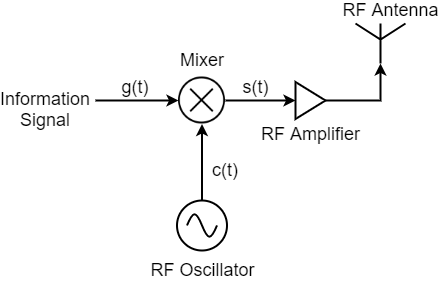


In [2]:
fs = 1000000 # sample rate 
fb = 20000 # the frequency of the baseband signal
fc = 300000 # frequency of the carrier signal
A = 200 # baseband signal amplitude
n_window = fs # fft size

In [3]:
samples = np.arange(fs) # the points on the x axis for plotting - 0 to fs
t = samples/fs #samples per sampling rate - amount of time passed to process number of samples - array

freqs = np.fft.fftshift(np.fft.fftfreq(n_window,1/fs)) #frequency domain axis for graphs

First we define an input signal, $g(t)$:

$g(t) = A\cos(2 \pi f_{b} t)$

where A is the amplitude and $f_{b}$ is the frequency of the baseband signal.

For demonstration purposes a single tone signal will be used, however a more general baseband signal with frequency components from 0 to $f_{b}$ can be modulated with the same approach.

In [4]:
g = A*np.cos(2*np.pi*fb*t) 

This baseband information signal can be plotted in both time and frequency domains. 

We can observe a cosine with amplitude A in the time domain and a single tone at $f_{b}$ in the frequency domain.

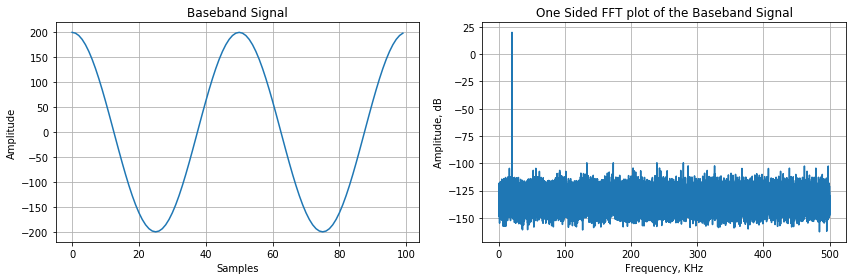

In [5]:
baseband_fft_db = find_fft(g, n_window)
time_title = 'Baseband Signal'
freq_title = 'One Sided FFT plot of the Baseband Signal'
subplots(g, baseband_fft_db, samples, freqs, fs, time_title, freq_title)

Similarly, a high frequency carrier signal can be defined. 

$c(t) = \cos(2 \pi f_{c} t)$

In [6]:
c = np.cos(2*np.pi*fc*t) 

We can now plot this carrier signal in time and frequency domains.

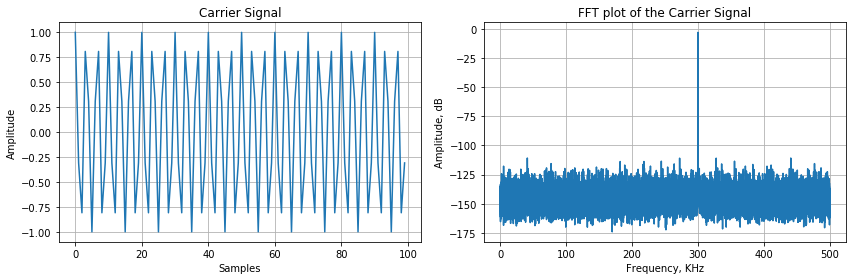

In [7]:
carrier_fft_db = find_fft(c, n_window)
time_title = 'Carrier Signal'
freq_title = 'FFT plot of the Carrier Signal'
subplots(c, carrier_fft_db, samples, freqs, fs, time_title, freq_title)

A modulated signal, $s(t)$, can now be obtained by multiplying our information signal, $g(t)$, by the carrier signal $c(t)$.

$s(t) = c(t) \times g(t)$

$s(t) = \cos(2 \pi f_{c} t) \times A\cos(2 \pi f_{b} t)$

Using trigonometry we can see that:

$s(t) = \frac{A}{2} \cos(2 \pi (f_{c} - f_{b}) t) + \frac{A}{2} \cos(2 \pi (f_{c} + f_{b}) t)$

In Python, this modulated signal can be easily obtained by mutliplying the carrier signal $c(t)$ by the information signal, $g(t)$:


In [8]:
s = g*c #information signal g(t) multiplied by carrier signal c(t)

We can plot the results of this modulation in time and frequency domain. 

In the frequency domain we can see frequency responses at $f_{c} - f_{b}$ and $f_{c} + f_{b}$. Therefore we must transmit data using a bandwidth of $2 f_{b}$

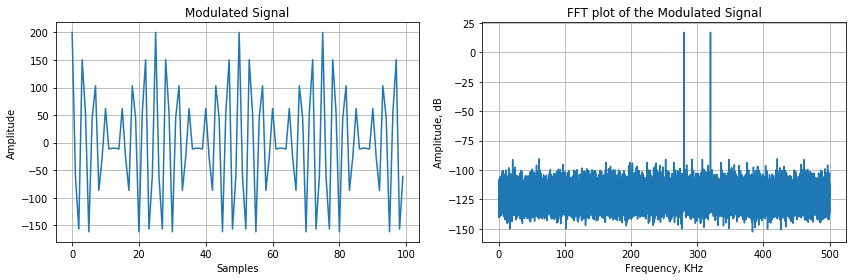

In [9]:
modulated_fft_db = find_fft(s, n_window)

time_title = 'Modulated Signal'
freq_title = 'FFT plot of the Modulated Signal'
subplots(s, modulated_fft_db, samples, freqs, fs, time_title, freq_title)

**Demodulation of the Baseband Signal**

At the receiver, this modulated signal can be 'perfectly' demodulated using a local carrier which matches the transmission carrier.

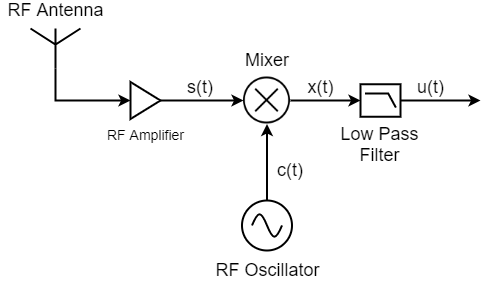

The modulated signal, $s(t)$, is multiplied by the carrier signal, $c(t)$, to produce a demodulated signal, $x(t)$.

$x(t) = c(t) \times s(t)$

$x(t) = \frac{A}{2} \cos(2 \pi f_{b} t) + \frac{A}{4} \cos(2 \pi (2f_{c} - f_{b}) t) + \frac{A}{4} \cos(2 \pi (2f_{c} + f_{b}) t)$

Within Python, this demodulation can be performed by multiplying the carrier signal, $c(t)$, by the received signal, $s(t)$.

In [10]:
x = c*s # multiplication of carrier and received signals to perform demodulation

This demodulated signal can now be plotted in time and frequency domains. 

We can see that the original information signal at $f_{b}$ has been successfully recovered, however unwanted high frequency components sitting around $2f_{c}$ are present.  

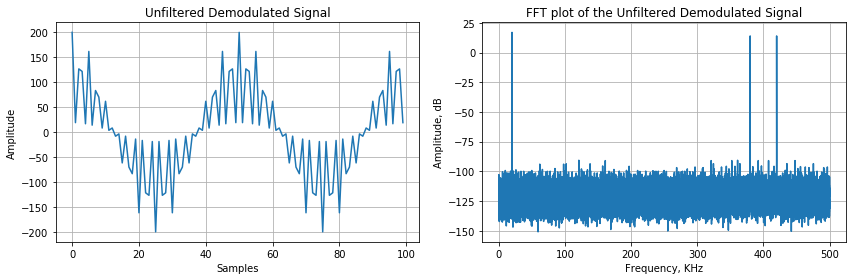

In [11]:
demodulated_fft_db = find_fft(x, n_window)

time_title = 'Unfiltered Demodulated Signal'
freq_title = 'FFT plot of the Unfiltered Demodulated Signal'
subplots(x, demodulated_fft_db, samples, freqs, fs, time_title, freq_title)

As we can see from the above figure, the demodulated signal has been successfully extracted, however unwanted high frequency components remain in the signal. These components can be removed using a lowpass filter, which we will design using the window method. This approach simply *windows* an ideal impulse response $h_d(n)$ by multiplying it by a window function $w(n)$:

$h(n) = w(n).h_d(n)$

For more information on filter design, please see the [Digital Filter Design notebook](./01_digital_filter_design.ipynb).

In [12]:
f_cutoff = 0.1 # Cutoff frequency as a fraction of the sampling rate
b = 0.08  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).

N = int(np.ceil((4 / b)))
if not N % 2: N += 1  # N is odd.
n = np.arange(N)

h = np.sinc(2 * f_cutoff * (n - (N - 1) / 2)) # Compute sinc filter.
w = np.blackman(N) # Compute Blackman window.
h = h * w # Multiply sinc filter by window.
h = h / np.sum(h) # Normalize to get unity gain.

The lowpass filter can be applied to the demodulated signal using convolution. Within Python this can be performed simply by using np.convolve().

In [13]:
u = np.convolve(x, h)

The results of this low pass filter can be plotted, alongside the unfiltered signal. 

The 'cost' of amplitude scaling demodulation, as the name suggests, is a 50% amplitude scaling. This is particularly clear in the time domain plot. In the frequency domain we can clearly see that the high frequency components are removed, leaving only the desired baseband signal.

With the removal of the high frequency components, the desired output can be obtained as:

$u(t) = \frac{A}{2} \cos(2 \pi f_{b} t)$

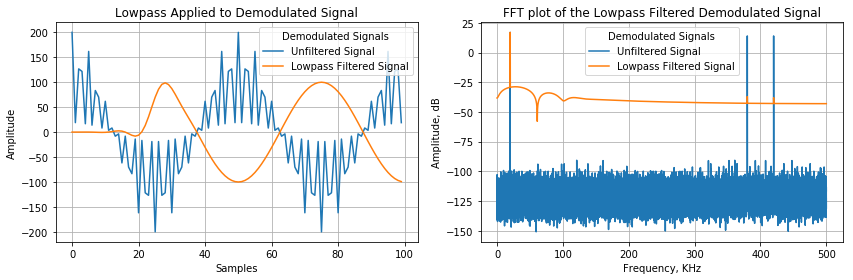

In [14]:
u_fft_db = find_fft(u, n_window)

time_title = 'Lowpass Applied to Demodulated Signal'
freq_title = 'FFT plot of the Lowpass Filtered Demodulated Signal'
label1 = 'Unfiltered Signal'
label2 = 'Lowpass Filtered Signal'
legend_title = 'Demodulated Signals'
#subplots(u[0:len(h)-1], u_fft_db, samples[0:len(h)-1], freqs, fs, time_title, freq_title)
multi_subplots(x, u, demodulated_fft_db, u_fft_db, samples, freqs, fs, 
               time_title, freq_title, label1, label2, legend_title)

**Demodulation Phase Error**

If the local oscillator is not exactly in phase with the received signal, the resulting phase error will cause an attenuation by a factor of $\cos(\theta)$.

In [15]:
phaseshift = (np.pi/3) #60 degree phase shift
phase_carrier = np.cos(2*np.pi*fc*t + phaseshift)
phase_modulation = phase_carrier*s

lowpass_phaseshift = np.convolve(phase_modulation, h)

This concept can be shown by plotting the low pass filtered demodulated signal again, but incorporating a phase error into the local carrier signal.

By using a phase error of $\frac{\pi}{3}$ we observe an attenuation of $\cos(\frac{\pi}{3}) = 0.5.$

Therefore, in the time domain we can observe an amplitude of $\frac{A}{4}$ compared to the transmitted signal. 

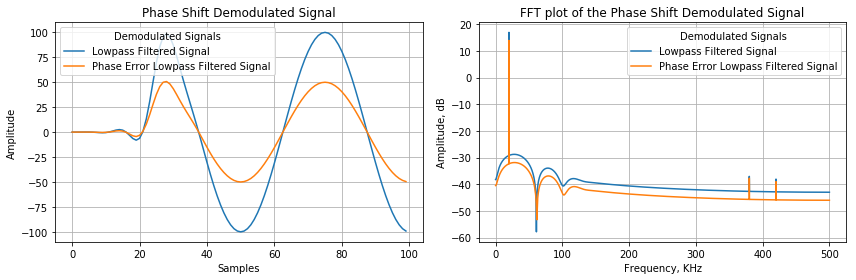

In [16]:
phaseshift_fft_db = find_fft(lowpass_phaseshift, n_window)

time_title = 'Phase Shift Demodulated Signal'
freq_title = 'FFT plot of the Phase Shift Demodulated Signal'
label1 = 'Lowpass Filtered Signal'
label2 = 'Phase Error Lowpass Filtered Signal'
legend_title = 'Demodulated Signals'

multi_subplots(u, lowpass_phaseshift, u_fft_db, phaseshift_fft_db, samples, freqs, fs, 
               time_title, freq_title, label1, label2, legend_title)


So far we have shown how amplitude modulation may be used to transmit a baseband signal at much higher frequencies whilst being able to recreate the original signal at the receiver. However we have encountered two issues:

1. Spectral inefficiency: the baseband is $f_{b}$ Hz wide but the modulated signal is $2f_{b}$. Therefore we require double the bandwidth to transmit the signal.

2. We assume that the local oscillator at the receiver is exactly in phase and of the same frequency as the transmitter. This clearly will not always be the case in a real system.

## QAM and QAM Demodulation

**QAM Modulation**

Quadrature Amplitude Modulation can be used to achieve more bandwidth efficient signalling. Using this approach two signals are transmitted in the same frequency band, using quadrature carriers.  

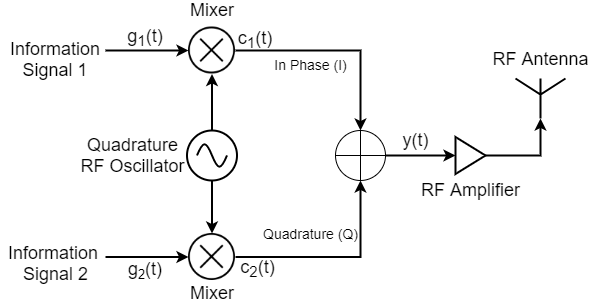

First we describe two information signals. For this demonstration, $g_{1}(t)$ is the same tone as used previously, whilst $g_{2}(t)$ is a tone at a lower frequency. In this way, both tones can be transmitted using the same bandwidth as shown in the previous example.

In [17]:
fb2 = 10000

g1 = 200*np.cos(2*np.pi*fb*t)
g2 = 100*np.cos(2*np.pi*fb2*t)

These two signals can be plotted together on time and frequency domains.

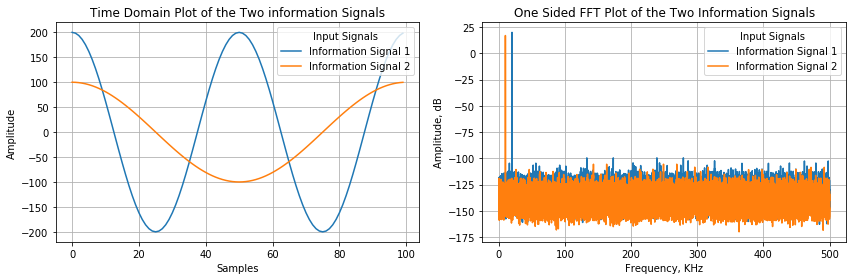

In [18]:
g1_fft_db = find_fft(g1, n_window)
g2_fft_db = find_fft(g2, n_window)

time_title = 'Time Domain Plot of the Two information Signals'
freq_title = 'One Sided FFT Plot of the Two Information Signals'
label_I = 'Information Signal 1'
label_Q = 'Information Signal 2'
legend_title = 'Input Signals'

multi_subplots(g1, g2, g1_fft_db, g2_fft_db, samples, freqs, fs, time_title, freq_title, label_I, label_Q, legend_title)

These two information signals are mixed using quadrature carriers to give modulated signals which are 90 degrees out of phase.

$c_{1}(t) = g_{1}(t) \cos(2 \pi f_{c} t)$

$c_{2}(t) = -g_{2}(t) \sin(2 \pi f_{c} t)$

Where $f_{c}$ is the carrier frequency used in the previous example.

In [19]:
c1 = g1*np.cos(2*np.pi*fc*t)
c2 = -g2*np.sin(2*np.pi*fc*t)

We can now plot the I and Q modulated signals. It is clear in the frequency domain that the bandwidth remains $2f_{b}$ as we can see maximum and minimum frequency responses at $f_{c} - f_{b}$ and $f_{c} + f_{b}$ respectively.

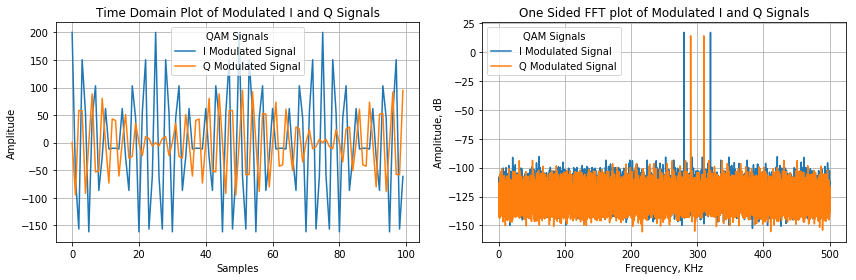

In [20]:
c1_fft_db = find_fft(c1, n_window)
c2_fft_db = find_fft(c2, n_window)

time_title = 'Time Domain Plot of Modulated I and Q Signals'
freq_title = 'One Sided FFT plot of Modulated I and Q Signals'
label_I = 'I Modulated Signal'
label_Q = 'Q Modulated Signal'
legend_title = 'QAM Signals'

multi_subplots(c1, c2, c1_fft_db, c2_fft_db, samples, freqs, fs, time_title, freq_title, label_I, label_Q, legend_title)

These signals can then be summed together to create a single signal, $y(t)$, which contains both information signals. 

$y(t) = g_{1}(t) \cos(2 \pi f_{c} t) - g_{2}(t) \sin(2 \pi f_{c} t)$

This way, two signals can be transmitted using a bandwidth of $2f_{b}$.

Within Python, this is a simple case of summing together the two modulated signals, $c_{1}$ and $c_{2}$:

In [21]:
y = c1 + c2 # sum of modulated signals

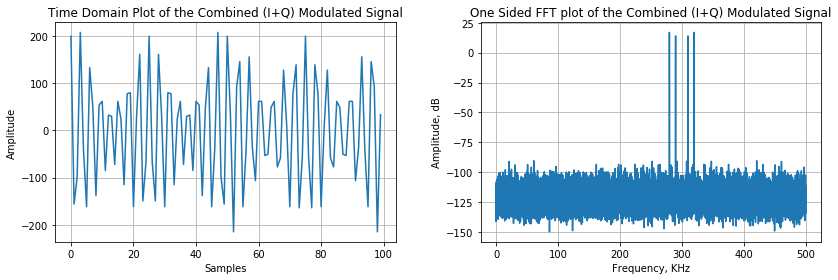

In [22]:
y_fft_db = find_fft(y, n_window)

time_title = 'Time Domain Plot of the Combined (I+Q) Modulated Signal'
freq_title = 'One Sided FFT plot of the Combined (I+Q) Modulated Signal'
subplots(y, y_fft_db, samples, freqs, fs, time_title, freq_title)

**QAM Demodulation**

At the receiver, quadrature demodulation involves multiplying the received signal by sine and cosine terms.

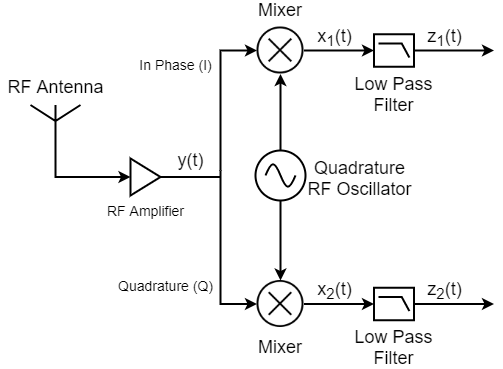

For the In Phase channel, I, the output after the demodulator is:  

$x_{1}(t) = y(t) \cos(2 \pi f_{c} t)$

$x_{1}(t) = 0.5g_{1}(t) + 0.5g_{1}(t) \cos(4 \pi f_{c} t) - 0.5g_{2}(t) \sin (4 \pi f_{c} t)$

Similarly, for the Quadrature Phase channel, Q, the output after the demodulator is:

$x_{2}(t) = y(t)( -\sin(2 \pi f_{c} t))$

$x_{2}(t) = 0.5g_{2}(t) - 0.5g_{1}(t) \sin(4 \pi f_{c} t) + 0.5g_{2}(t) \cos (4 \pi f_{c} t)$

In [23]:
x1 = y*np.cos(2*np.pi*fc*t)
x2 = y*(-np.sin(2*np.pi*fc*t))

As can be seen from the below plots, the desired baseband frequency components have been reconstructed, however as in Amplitude Modulation, unwanted high frequency components are still present in the signal.

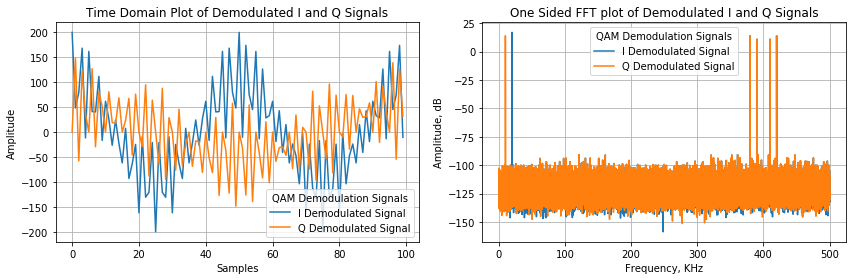

In [24]:
x1_fft_db = find_fft(x1, n_window)
x2_fft_db = find_fft(x2, n_window)

time_title = 'Time Domain Plot of Demodulated I and Q Signals'
freq_title = 'One Sided FFT plot of Demodulated I and Q Signals'
label_I = 'I Demodulated Signal'
label_Q = 'Q Demodulated Signal'
legend_title = 'QAM Demodulation Signals'

multi_subplots(x1, x2, x1_fft_db, x2_fft_db, samples, freqs, fs, time_title, freq_title, label_I, label_Q, legend_title)

Low pass filters are used to remove the high frequency terms so that the information can be perfectly recovered. 

$z_{1}(t) = 0.5g_{1}(t)$

$z_{2}(t) = 0.5g_{2}(t)$

In [25]:
z1 = np.convolve(x1, h)
z2 = np.convolve(x2, h)

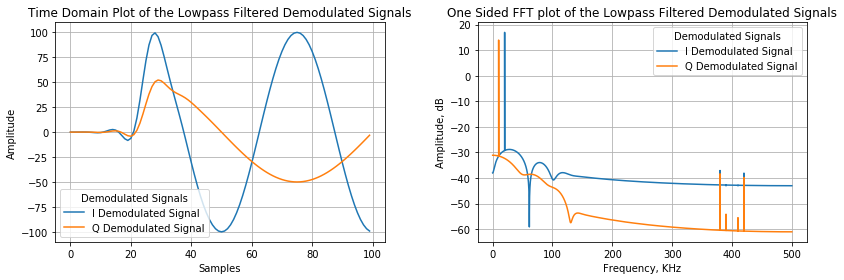

In [26]:
z1_fft_db = find_fft(z1, n_window)
z2_fft_db = find_fft(z2, n_window)

time_title = 'Time Domain Plot of the Lowpass Filtered Demodulated Signals'
freq_title = 'One Sided FFT plot of the Lowpass Filtered Demodulated Signals'
label_I = 'I Demodulated Signal'
label_Q = 'Q Demodulated Signal'
legend_title = 'Demodulated Signals'

multi_subplots(z1, z2, z1_fft_db, z2_fft_db, samples, freqs, fs, time_title, freq_title, label_I, label_Q, legend_title)

**Phase Error With QAM**

If the receivers local oscillator is shifted by $\theta$ with respect to the received signal, then the In Phase and Quadrature output signals will be mixed. 

For the I channel:

$x_{1}(t) = y(t) \cos(2 \pi f_{c} t + \theta)$

$x_{1}(t) = 0.5 [g_{1}t \cos(\theta) + g_{2}(t) \sin(\theta)]$

For the Q channel:

$x_{2}(t) = y(t) (-\sin(2 \pi f_{c} t + \theta))$

$x_{2}(t) = 0.5 [-g_{1}t \sin(\theta) + g_{2}(t) \cos(\theta)]$

In [27]:
x1_phaseshift = y*np.cos(2*np.pi*fc*t + phaseshift)
x2_phaseshift = y*(-np.sin(2*np.pi*fc*t + phaseshift))

lp_x1_phaseshift = np.convolve(x1_phaseshift, h)
lp_x2_phaseshift = np.convolve(x2_phaseshift, h)

From the below plots it is clear that frequency components from $g_{1}(t)$ and $g_{2}(t)$ are present in both I and Q channels. The time domain plot also shows these mixed signals, the clear 90 degree phase shifts seen earlier are no longer presents and the signals can be seen to be composed of multiple components.

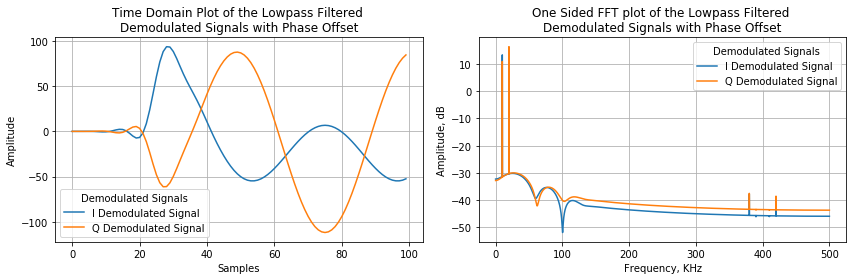

In [28]:
lp_x1_phaseshift_fft_db = find_fft(lp_x1_phaseshift, n_window)
lp_x2_phaseshift_fft_db = find_fft(lp_x2_phaseshift, n_window)

time_title = 'Time Domain Plot of the Lowpass Filtered \nDemodulated Signals with Phase Offset'
freq_title = 'One Sided FFT plot of the Lowpass Filtered \nDemodulated Signals with Phase Offset'
label_I = 'I Demodulated Signal'
label_Q = 'Q Demodulated Signal'
legend_title = 'Demodulated Signals'

multi_subplots(lp_x1_phaseshift, lp_x2_phaseshift, lp_x1_phaseshift_fft_db, lp_x2_phaseshift_fft_db, samples, freqs, fs,
            time_title, freq_title, label_I, label_Q, legend_title)

The I and Q signals are interfering with each other due to the phase error. DSP receivers can be designed to calculate these phase errors and unmix the signals. 

## Complex Representation of QAM

The QAM model we have looked at so far has used two real signals as the input, however a complex representation is also possible.

**Complex Modulation**

Consider a complex baseband notation:

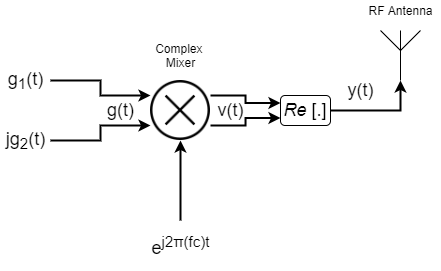

where:

$g(t) = g_{1}(t) + jg_{2}(t)$

and $g_{1}$ and $g_{2}$ are the same signals used in the QAM modulation example. 

In [29]:
g_complex = g1 + 1j*(g2)

If we plot this complex information signal as before, we can observe that the information signal matches $g_{1}$ and $g_{2}$ previously shown in the QAM example.

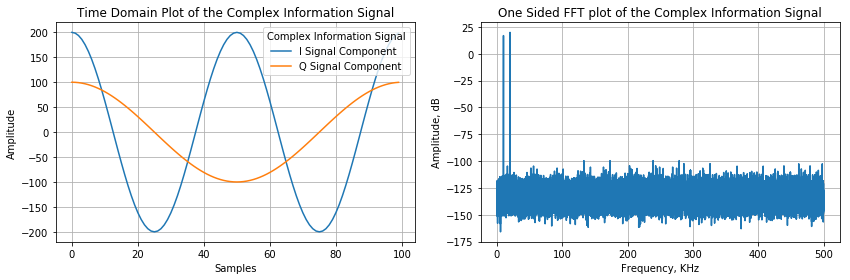

In [30]:
g_complex_fft_db = find_fft(g_complex, n_window)

time_title = 'Time Domain Plot of the Complex Information Signal'
freq_title = 'One Sided FFT plot of the Complex Information Signal'
label_I = 'I Signal Component'
label_Q = 'Q Signal Component'
legend_title = 'Complex Information Signal'

complex_subplots(g_complex.real, g_complex.imag, g_complex_fft_db, samples, freqs, fs,
                 label_I, label_Q, time_title, freq_title, legend_title)

This complex information signal can be modulated using a complex exponential at a 'frequency' of $f_{c}$ Hz:

$e^{j 2 \pi f_{c} t} = \cos (2 \pi f_{c} t) + j \sin (2 \pi f_{c} t)$

In [31]:
c_complex = np.exp(1j*2*np.pi*fc*t)

We can observe that this is equivalant to the carrier signal used previously.

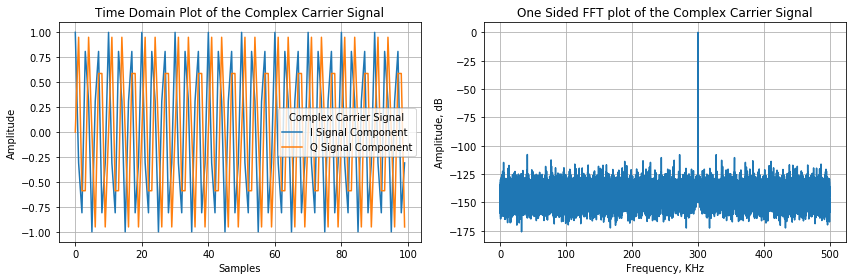

In [32]:
c_complex_fft_db = find_fft(c_complex, n_window)

time_title = 'Time Domain Plot of the Complex Carrier Signal'
freq_title = 'One Sided FFT plot of the Complex Carrier Signal'
label_I = 'I Signal Component'
label_Q = 'Q Signal Component'
legend_title = 'Complex Carrier Signal'

complex_subplots(c_complex.real, c_complex.imag, c_complex_fft_db, samples, freqs, fs,
                 label_I, label_Q, time_title, freq_title, legend_title)

This modulator creates the following signal, achieved by multiplying $g(t)$ with $e^{j 2 \pi f_{c} t}$:

$v(t) = g(t)e^{j 2 \pi f_{c} t} = [g_{1}(t) + jg_{2}(t)]e^{j 2 \pi f_{c} t}$

$v(t) = [g_{1}(t) \cos (2 \pi f_{c} t) - g_{2}(t) \sin (2 \pi f_{c} t)] + j [g_{1}(t) \sin (2 \pi f_{c} t) + g_{2}(t) \cos(2 \pi f_{c} t)]$

In [33]:
v = g_complex*c_complex

The real part only is then retained and the imaginary part is removed using a Real operator leaving:

$y(t) = g_{1}(t) \cos (2 \pi f_{c} t) - g_{2}(t) \sin (2 \pi f_{c} t)$

In [34]:
y = v.real

We can observe from the below plots that this is mathematically identical to the combined QAM modulator $y(t)$ found in the QAM example.

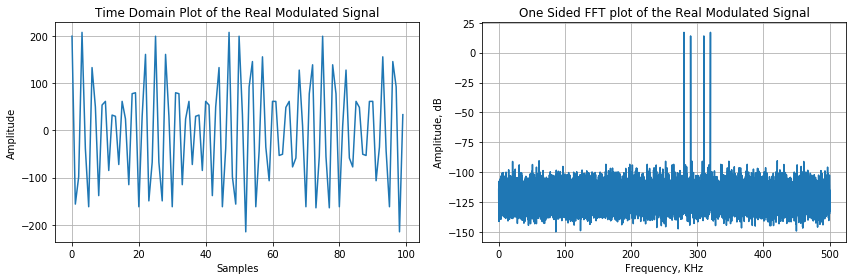

In [35]:
y_fft_db = find_fft(y, n_window)

time_title = 'Time Domain Plot of the Real Modulated Signal'
freq_title = 'One Sided FFT plot of the Real Modulated Signal'
subplots(y[0:fs], y_fft_db, samples, freqs, fs, time_title, freq_title)

**Complex Demodulation**

QAM Demodulation can also be expressed using a complex notation:

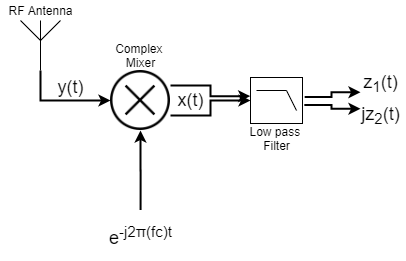

Where:

$x(t) = y(t)e^{j 2 \pi f_{c} t} = [g_{1}(t) \cos (2 \pi f_{c} t) - g_{2}(t) \sin (2 \pi f_{c} t)]e^{j 2 \pi f_{c} t}$

$x(t) = 0.5[g_{1}(t) + jg_{2}] + 0.5(g_{1}(t) \cos(4 \pi f_{c} t) - j0.5(g_{2}(t) \cos(4 \pi f_{c} t) - j0.5(g_{1}(t) \sin(4 \pi f_{c} t) - 0.5(g_{2}(t) \sin(4 \pi f_{c} t)$


In [36]:
complex_demod_carrier = np.exp(-1j*2*np.pi*fc*t)
x = y*complex_demod_carrier

From the plot of this demodulated signal we can see that the unwanted high frequency components are most obvious in the time domain spectrum, occuring at $4 \pi f_{c} t$.

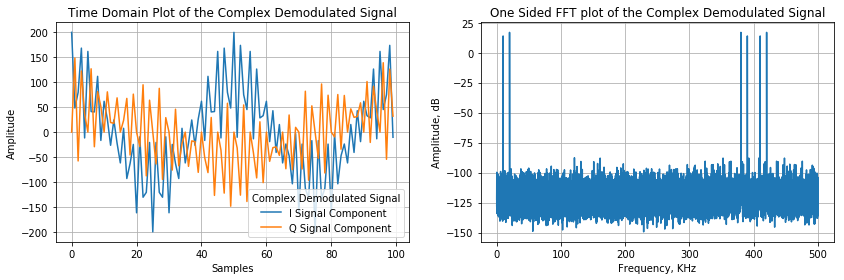

In [37]:
x_fft_db = find_fft(x, n_window)

time_title = 'Time Domain Plot of the Complex Demodulated Signal'
freq_title = 'One Sided FFT plot of the Complex Demodulated Signal'
label_I = 'I Signal Component'
label_Q = 'Q Signal Component'
legend_title = 'Complex Demodulated Signal'

complex_subplots(x.real, x.imag, x_fft_db, samples, freqs, fs,
                 label_I, label_Q, time_title, freq_title, legend_title)

As before, we can apply a low pass filter to this signal to remove the unwanted components. This leaves:

$z(t) = 0.5[g_{1}(t) + jg_{2}]$ 

In [38]:
z = np.convolve(x, h)

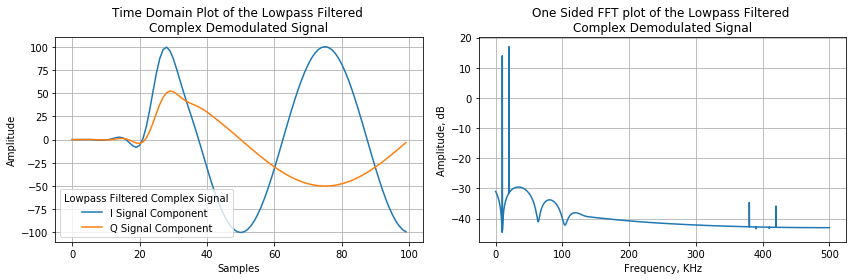

In [39]:
z_fft_db = find_fft(z, n_window)

time_title = 'Time Domain Plot of the Lowpass Filtered \nComplex Demodulated Signal'
freq_title = 'One Sided FFT plot of the Lowpass Filtered \nComplex Demodulated Signal'
label_I = 'I Signal Component'
label_Q = 'Q Signal Component'
legend_title = 'Lowpass Filtered Complex Signal'

complex_subplots(z.real, z.imag, z_fft_db, samples, freqs, fs, label_I, label_Q, time_title, freq_title, legend_title)

These two QAM architectures are mathematically identical, however the complex representation is an easier architecture to work with, and working with complex exponentials is much easier and more tractable than working with the cosine and standard QAM form.